In [178]:
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='Datetime'>

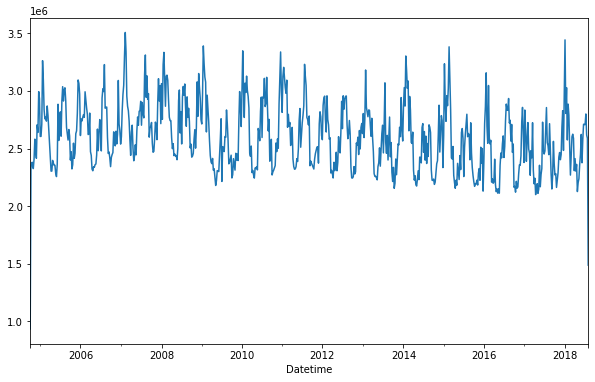

In [202]:

data = pd.read_csv(open('/media/saros/Store/Dev/Power-Usage/AEP_hourly.csv','r'),index_col="Datetime")['AEP_MW']
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')


data = data.resample('W').sum()

data.plot()


In [203]:
# Mean/Variance for the raw data
# Results in a high variance
mean = data.mean()
var = data.var()
print("Mean was  ", mean)
print("Variance was  " ,  var)

Mean was   2599823.6887966804
Variance was   83127453734.27837


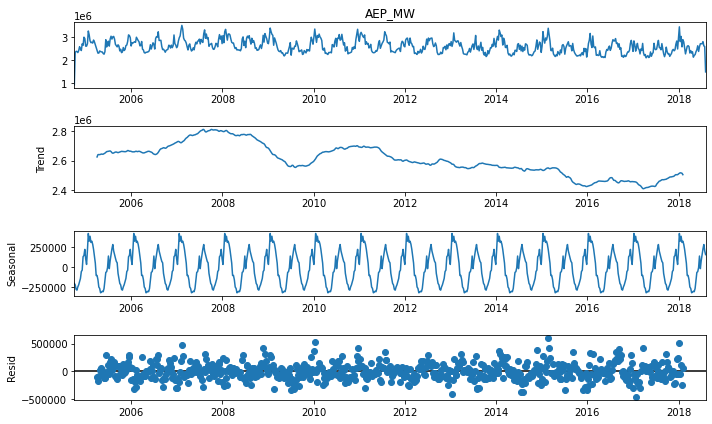

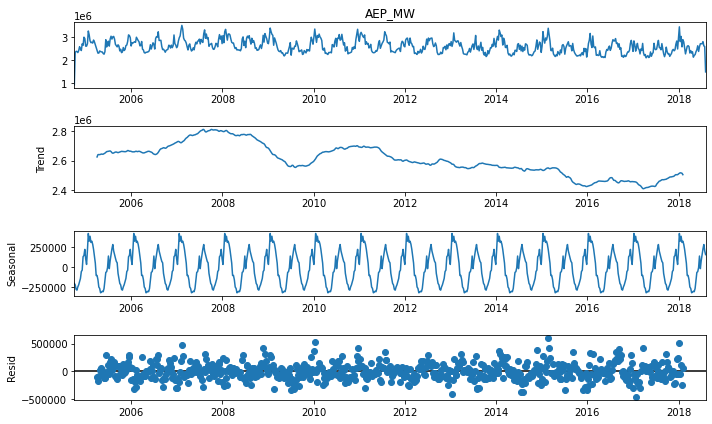

In [204]:
result = seasonal_decompose(data, model='additive')
result.plot()


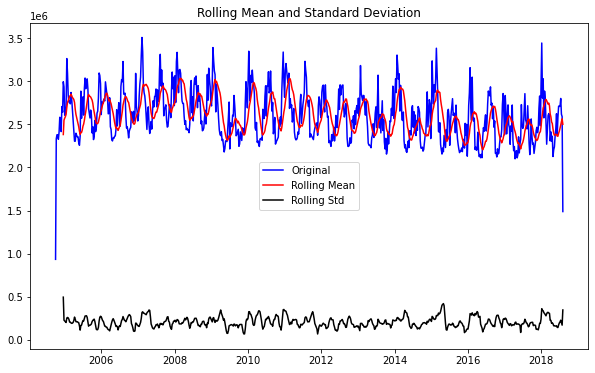

Results of dickey fuller test
Test Statistics                 -3.211035
p-value                          0.019355
No. of lags used                20.000000
Number of observations used    702.000000
critical value (1%)             -3.439700
critical value (5%)             -2.865666
critical value (10%)            -2.568967
dtype: float64


In [205]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)


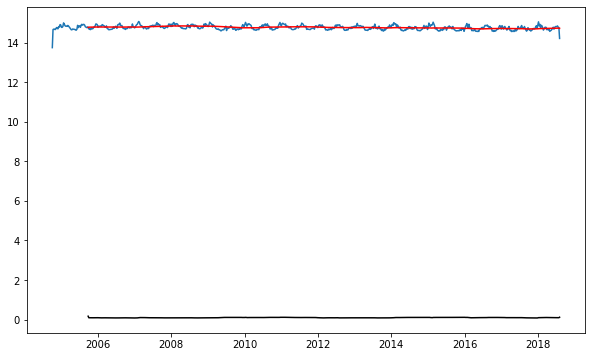

In [206]:
df_log = np.log(data)
moving_avg = df_log.rolling(52).mean()
std_dev = df_log.rolling(52).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

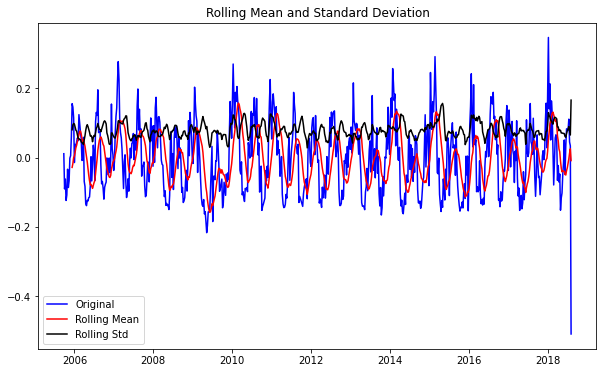

Results of dickey fuller test
Test Statistics               -1.068336e+01
p-value                        3.889017e-19
No. of lags used               8.000000e+00
Number of observations used    6.630000e+02
critical value (1%)           -3.440252e+00
critical value (5%)           -2.865909e+00
critical value (10%)          -2.569097e+00
dtype: float64


In [207]:
test_stationarity(df_log_moving_avg_diff)

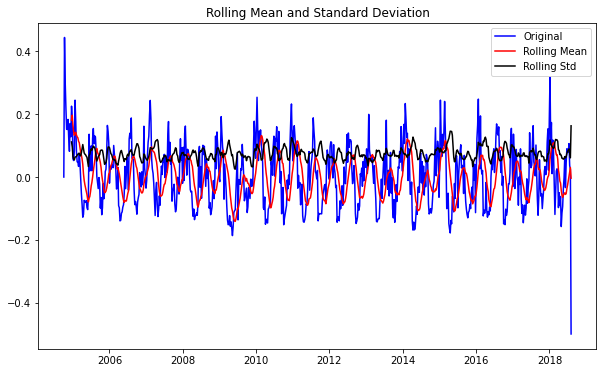

Results of dickey fuller test
Test Statistics               -9.964539e+00
p-value                        2.325768e-17
No. of lags used               1.300000e+01
Number of observations used    7.090000e+02
critical value (1%)           -3.439607e+00
critical value (5%)           -2.865625e+00
critical value (10%)          -2.568945e+00
dtype: float64


In [209]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

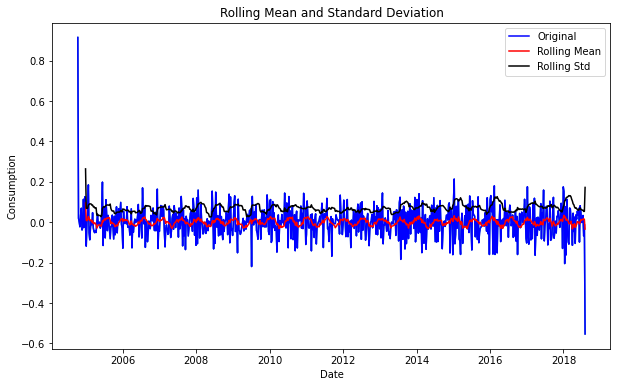

Results of dickey fuller test
Test Statistics               -1.284235e+01
p-value                        5.572413e-24
No. of lags used               1.900000e+01
Number of observations used    7.020000e+02
critical value (1%)           -3.439700e+00
critical value (5%)           -2.865666e+00
critical value (10%)          -2.568967e+00
dtype: float64


In [210]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)
#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

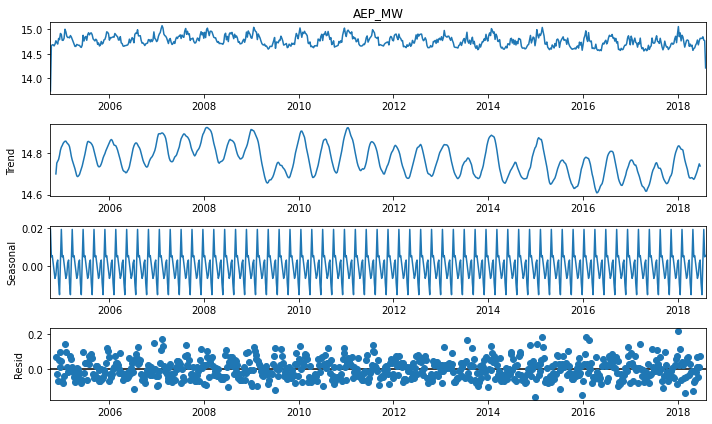

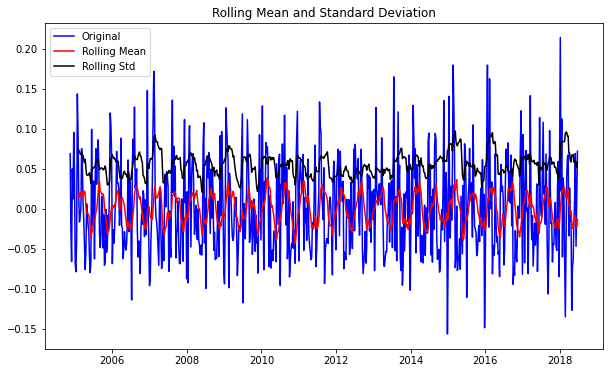

Results of dickey fuller test
Test Statistics               -1.307983e+01
p-value                        1.880843e-24
No. of lags used               2.000000e+01
Number of observations used    6.900000e+02
critical value (1%)           -3.439863e+00
critical value (5%)           -2.865738e+00
critical value (10%)          -2.569005e+00
dtype: float64


In [211]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity(residual)

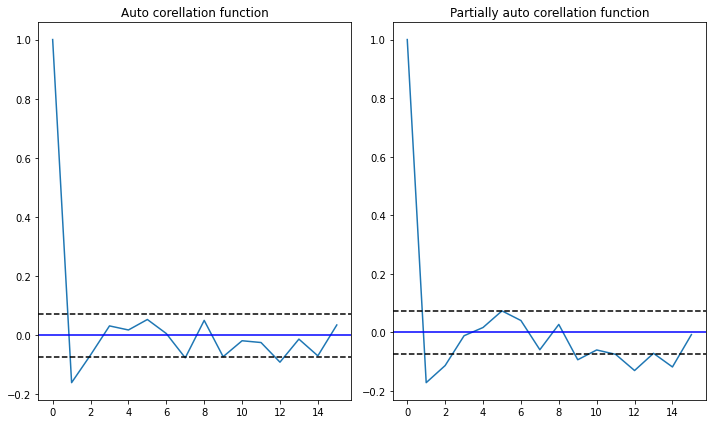

In [212]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()